In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


(np.float64(-0.44218684126923014), np.float64(0.5197233512030557), 0, 99, {'1%': np.float64(-2.5886939026629934), '5%': np.float64(-1.9440242848853808), '10%': np.float64(-1.6143879418406077)}, np.float64(261.03478690611325))
(np.float64(-2.159064083730297), np.float64(0.2214367224218049), 0, 99, {'1%': np.float64(-3.498198082189098), '5%': np.float64(-2.891208211860468), '10%': np.float64(-2.5825959973472097)}, np.float64(259.024823987493))
(np.float64(-3.1529806081248855), np.float64(0.09418448509704919), 1, 98, {'1%': np.float64(-4.054251125423931), '5%': np.float64(-3.4562790670553936), '10%': np.float64(-3.153866135708761)}, np.float64(258.1449606439513))
(np.float64(-0.8409663060118324), np.float64(0.35336643722741234), 0, 99, {'1%': np.float64(-2.5886939026629934), '5%': np.float64(-1.9440242848853808), '10%': np.float64(-1.6143879418406077)}, np.float64(238.0116920703609))
(np.float64(-2.128651670603921), np.float64(0.23315075389155704), 0, 99, {'1%': np.float64(-3.498198082189

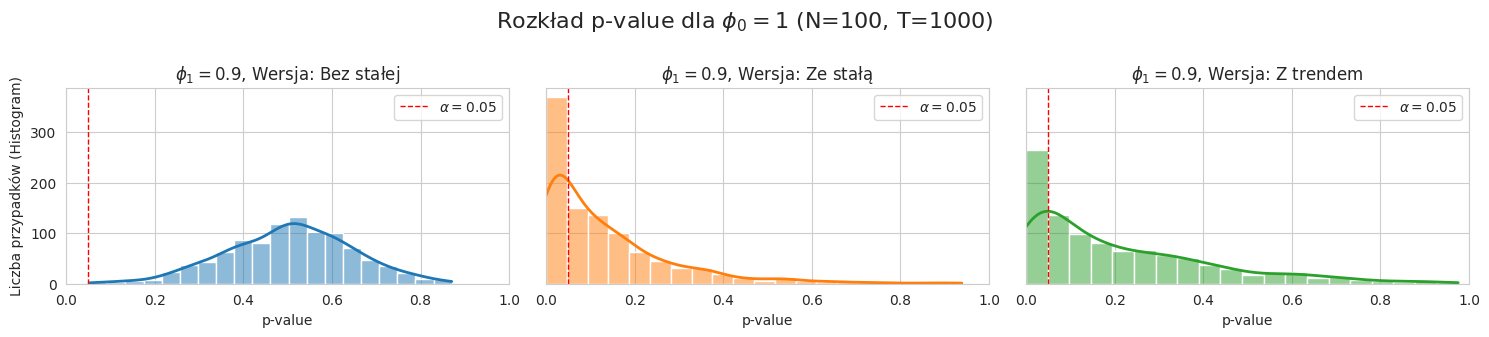

In [2]:
N = 100
T = 1000
sigma2 = 1.0
sigma = np.sqrt(sigma2)

# Zestawy parametrów
# phi0_vals = [0, 1, 5, 10]
# phi1_vals = [-0.9, -0.5, -0.1, 0, 0.1, 0.5, 0.9]
phi0_vals = [1]
phi1_vals = [0.9]
alpha = 0.05

results = {}

# Pętla po wszystkich kombinacjach parametrów
for phi0 in phi0_vals:
    for phi1 in phi1_vals:
        key = f"phi0={phi0}, phi1={phi1}"
        results[key] = {
            'n_pvalue': [],
            'c_pvalue': [],
            'ct_pvalue': [],
        }

        nc_rejects = 0
        c_rejects = 0
        ct_rejects = 0


        for t_run in range(T):

            # 1. Generowanie N wartości modelu AR(1): X_t = phi0 + phi1*X_{t-1} + eps_t
            n = N + 1000
            X = np.zeros(n)
            epsilon = np.random.normal(0, sigma, n)

            X[0] = phi0 / (1 - phi1)

            for t in range(1, n):
                X[t] = phi0 + phi1 * X[t-1] + epsilon[t]

            X_series = X[1000:]

            # Wersja 1: bez stałej (typ 'n')
            adf_n = adfuller(X_series, regression='n')
            p_value_n = adf_n[1]
            results[key]['n_pvalue'].append(p_value_n)

            # Wersja 2: ze stałą (typ 'c')
            adf_c = adfuller(X_series, regression='c')
            p_value_c = adf_c[1]
            results[key]['c_pvalue'].append(p_value_c)

            # Wersja 3: z trendem liniowym (typ 'ct')
            adf_ct = adfuller(X_series, regression='ct')
            p_value_ct = adf_ct[1]
            results[key]['ct_pvalue'].append(p_value_ct)

            if p_value_n < alpha:
                nc_rejects += 1
            if p_value_c < alpha:
                c_rejects += 1
            if p_value_ct < alpha:
                ct_rejects += 1

        results[key]['n_reject_rate'] = nc_rejects / T
        results[key]['c_reject_rate'] = c_rejects / T
        results[key]['ct_reject_rate'] = ct_rejects / T


summary_df_data = []
all_pvalues_for_plot = []

for key, data in results.items():
    phi0 = float(key.split(', ')[0].split('=')[1])
    phi1 = float(key.split(', ')[1].split('=')[1])

    for version in ['n', 'c', 'ct']:
        p_values = np.array(data[f'{version}_pvalue'])
        reject_rate = data[f'{version}_reject_rate']

        mean_p = np.mean(p_values)
        median_p = np.median(p_values)
        std_p = np.std(p_values)

        summary_df_data.append({
            'phi0': phi0,
            'phi1': phi1,
            'Wersja ADF': version,
            'Średnia p-value': f"{mean_p:.4f}",
            'Mediana p-value': f"{median_p:.4f}",
            'Odch. std. p-value': f"{std_p:.4f}",
            'Odsetek odrzuceń H0 (%)': f"{reject_rate * 100:.2f}"
        })

        all_pvalues_for_plot.append({
            'p_value': p_values,
            'phi0': phi0,
            'phi1': phi1,
            'Wersja ADF': version
        })

summary_df = pd.DataFrame(summary_df_data)

print("\n")
print("Statystyki Opisowe i Potęga Testu ADF (N=100, T=1000)")
print("\n")

print(summary_df.to_markdown(index=False))

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)

print("\n")
print("Rozkłady p-value dla wybranych kombinacji parametrów")
print("\n")

for plot_phi0 in phi0_vals:
    plot_data = [d for d in all_pvalues_for_plot if d['phi0'] == plot_phi0]

    if not plot_data:
        continue

    n_rows = len(phi1_vals)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3.5 * n_rows), sharex=True, sharey=True)
    axes = np.atleast_2d(axes)

    fig.suptitle(f'Rozkład p-value dla $\\phi_0={plot_phi0}$ (N={N}, T={T})', fontsize=16)

    for i, phi1 in enumerate(phi1_vals):
        for j, version in enumerate(['n', 'c', 'ct']):
            ax = axes[i, j]

            data = next(d for d in plot_data if d['phi1'] == phi1 and d['Wersja ADF'] == version)
            p_values = data['p_value']

            version_label = {'n': 'Bez stałej', 'c': 'Ze stałą', 'ct': 'Z trendem'}[version]

            sns.histplot(p_values, bins=20, kde=True, ax=ax, color=sns.color_palette("tab10")[j],
                         line_kws={'linewidth': 2})

            ax.set_title(f'$\\phi_1={phi1}$, Wersja: {version_label}')
            ax.set_xlabel('p-value')
            if j == 0:
                ax.set_ylabel(f'Liczba przypadków (Histogram)')

            ax.axvline(alpha, color='r', linestyle='--', linewidth=1, label=f'$\\alpha={alpha}$')
            ax.legend()
            ax.set_xlim(0, 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


In [ ]:

# Parametry bazowe
T = 1000
sigma2 = 1.0
sigma = np.sqrt(sigma2)

# Zestawy parametrów
phi0_vals = [0, 1, 5, 10]
phi1_vals = [-0.9, -0.5, -0.1, 0, 0.1, 0.5, 0.9]
alpha = 0.05

# Różne długości danych do przetestowania
N_vals = [20, 100, 500]

# Słownik przechowujący wyniki dla każdego N
all_results = {}

# Pętla po różnych długościach danych
for N in N_vals:
    print(f"\n{'='*80}")
    print(f"Rozpoczynam symulacje dla N = {N}")
    print(f"{'='*80}\n")

    results = {}

    # Pętla po wszystkich kombinacjach parametrów
    for phi0 in phi0_vals:
        for phi1 in phi1_vals:
            key = f"phi0={phi0}, phi1={phi1}"
            results[key] = {
                'n_pvalue': [],
                'c_pvalue': [],
                'ct_pvalue': [],
            }

            nc_rejects = 0
            c_rejects = 0
            ct_rejects = 0

            for t_run in range(T):

                # 1. Generowanie N wartości modelu AR(1): X_t = phi0 + phi1*X_{t-1} + eps_t
                n = N + 1000
                X = np.zeros(n)
                epsilon = np.random.normal(0, sigma, n)

                X[0] = phi0 / (1 - phi1) if phi1 != 1 else phi0

                for t in range(1, n):
                    X[t] = phi0 + phi1 * X[t-1] + epsilon[t]

                X_series = X[1000:]

                # Wersja 1: bez stałej (typ 'n')
                adf_n = adfuller(X_series, regression='n')
                p_value_n = adf_n[1]
                results[key]['n_pvalue'].append(p_value_n)

                # Wersja 2: ze stałą (typ 'c')
                adf_c = adfuller(X_series, regression='c')
                p_value_c = adf_c[1]
                results[key]['c_pvalue'].append(p_value_c)

                # Wersja 3: z trendem liniowym (typ 'ct')
                adf_ct = adfuller(X_series, regression='ct')
                p_value_ct = adf_ct[1]
                results[key]['ct_pvalue'].append(p_value_ct)

                if p_value_n < alpha:
                    nc_rejects += 1
                if p_value_c < alpha:
                    c_rejects += 1
                if p_value_ct < alpha:
                    ct_rejects += 1

            results[key]['n_reject_rate'] = nc_rejects / T
            results[key]['c_reject_rate'] = c_rejects / T
            results[key]['ct_reject_rate'] = ct_rejects / T

    # Zapisz wyniki dla tego N
    all_results[N] = results

    # Przygotowanie danych do tabeli
    summary_df_data = []
    all_pvalues_for_plot = []

    for key, data in results.items():
        phi0 = float(key.split(', ')[0].split('=')[1])
        phi1 = float(key.split(', ')[1].split('=')[1])

        for version in ['n', 'c', 'ct']:
            p_values = np.array(data[f'{version}_pvalue'])
            reject_rate = data[f'{version}_reject_rate']

            mean_p = np.mean(p_values)
            median_p = np.median(p_values)
            std_p = np.std(p_values)

            summary_df_data.append({
                'phi0': phi0,
                'phi1': phi1,
                'Wersja ADF': version,
                'Średnia p-value': f"{mean_p:.4f}",
                'Mediana p-value': f"{median_p:.4f}",
                'Odch. std. p-value': f"{std_p:.4f}",
                'Odsetek odrzuceń H0 (%)': f"{reject_rate * 100:.2f}"
            })

            all_pvalues_for_plot.append({
                'p_value': p_values,
                'phi0': phi0,
                'phi1': phi1,
                'Wersja ADF': version
            })

    summary_df = pd.DataFrame(summary_df_data)
    summary_df.to_csv(f"adf_power_comparison(N={N}, T={T}).csv", index=False)

    print(f"\nStatystyki Opisowe i Potęga Testu ADF (N={N}, T={T})")
    print("\n")
    print(summary_df.to_markdown(index=False))

    # Generowanie wykresów dla wybranych kombinacji
    sns.set_style("whitegrid")

    print(f"\n\nRozkłady p-value dla N={N}")
    print("\n")

    for plot_phi0 in phi0_vals:
        plot_data = [d for d in all_pvalues_for_plot if d['phi0'] == plot_phi0]

        if not plot_data:
            continue

        n_rows = len(phi1_vals)
        n_cols = 3
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3.5 * n_rows), sharex=True, sharey=True)
        axes = np.atleast_2d(axes)

        fig.suptitle(f'Rozkład p-value dla $\\phi_0={plot_phi0}$ (N={N}, T={T})', fontsize=16)

        for i, phi1 in enumerate(phi1_vals):
            for j, version in enumerate(['n', 'c', 'ct']):
                ax = axes[i, j]

                data = next(d for d in plot_data if d['phi1'] == phi1 and d['Wersja ADF'] == version)
                p_values = data['p_value']

                version_label = {'n': 'Bez stałej', 'c': 'Ze stałą', 'ct': 'Z trendem'}[version]

                sns.histplot(p_values, bins=20, kde=True, ax=ax, color=sns.color_palette("tab10")[j],
                             line_kws={'linewidth': 2})

                ax.set_title(f'$\\phi_1={phi1}$, Wersja: {version_label}')
                ax.set_xlabel('p-value')
                if j == 0:
                    ax.set_ylabel(f'Liczba przypadków')

                ax.axvline(alpha, color='r', linestyle='--', linewidth=1, label=f'$\\alpha={alpha}$')
                ax.legend()
                ax.set_xlim(0, 1)

        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()

# Porównanie wyników dla różnych N
print(f"\n{'='*80}")
print("PODSUMOWANIE PORÓWNAWCZE DLA RÓŻNYCH WARTOŚCI N")
print(f"{'='*80}\n")

# Przykładowe porównanie odsetka odrzuceń dla wybranych parametrów
comparison_data = []
for N in N_vals:
    results = all_results[N]
    for key, data in results.items():
        phi0 = float(key.split(', ')[0].split('=')[1])
        phi1 = float(key.split(', ')[1].split('=')[1])

        comparison_data.append({
            'N': N,
            'phi0': phi0,
            'phi1': phi1,
            'Odrzucenia (n)': f"{data['n_reject_rate'] * 100:.1f}%",
            'Odrzucenia (c)': f"{data['c_reject_rate'] * 100:.1f}%",
            'Odrzucenia (ct)': f"{data['ct_reject_rate'] * 100:.1f}%"
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_markdown(index=False))
comparison_df.to_csv("adf_power_comparison.csv", index=False)


Rozpoczynam symulacje dla N = 20



KeyboardInterrupt: 

In [ ]:


# Konwersja wartości procentowych do liczb
for col in ["Odrzucenia (n)", "Odrzucenia (c)", "Odrzucenia (ct)"]:
    comparison_df[col] = comparison_df[col].str.replace('%', '').astype(float)

subset = comparison_df[comparison_df["N"] == 20]

sns.set(style="whitegrid", context="talk")

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

versions = [
    ("Odrzucenia (n)", "ADF (n) – bez stałej"),
    ("Odrzucenia (c)", "ADF (c) – ze stałą"),
    ("Odrzucenia (ct)", "ADF (ct) – z trendem")
]

for ax, (col, title) in zip(axes, versions):
    for phi0 in sorted(subset["phi0"].unique()):
        sub_phi0 = subset[subset["phi0"] == phi0]
        ax.plot(sub_phi0["phi1"], sub_phi0[col], 'o', markersize=8, label=f'φ0={phi0}')

    ax.set_title(title + "  (N=20)")
    ax.set_ylabel("Odrzucenia (%)")
    ax.grid(True, alpha=0.4)

axes[-1].set_xlabel("φ1")
fig.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), title="φ0")
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()